In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from datetime import datetime, timedelta

# --- 1. Define SMAPE and Data Extraction (MANUAL) ---

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

# Based on manual analysis of the provided PDF and JPEG files, I have extracted the key academic dates.
# This is a complex, multi-step process of reading text and calendars.
academic_calendar = {
    "2023_S2": {
        "start_date": datetime(2023, 8, 7),
        "end_date": datetime(2023, 12, 29),
        "exams": [
            (datetime(2023, 9, 25), datetime(2023, 9, 29)), # Solemne 1
            (datetime(2023, 11, 13), datetime(2023, 11, 17)), # Solemne 2
            (datetime(2023, 12, 11), datetime(2023, 12, 22)), # Examenes
        ]
    },
    "2024_S1": {
        "start_date": datetime(2024, 3, 11),
        "end_date": datetime(2024, 7, 19),
        "exams": [
            (datetime(2024, 4, 29), datetime(2024, 5, 3)), # Certamen 1
            (datetime(2024, 6, 17), datetime(2024, 6, 21)), # Certamen 2
            (datetime(2024, 7, 8), datetime(2024, 7, 19)), # Examenes
        ]
    },
    "2024_S2": {
        "start_date": datetime(2024, 8, 5),
        "end_date": datetime(2024, 12, 20),
        "exams": [
            (datetime(2024, 9, 23), datetime(2024, 9, 27)), # Certamen 1
            (datetime(2024, 11, 11), datetime(2024, 11, 15)), # Certamen 2
            (datetime(2024, 12, 9), datetime(2024, 12, 20)), # Examenes
        ]
    },
    "2025_S1": {
        "start_date": datetime(2025, 3, 10),
        "end_date": datetime(2025, 7, 18),
        "exams": [
            (datetime(2025, 4, 28), datetime(2025, 5, 2)),  # Certamen 1
            (datetime(2025, 6, 16), datetime(2025, 6, 20)),  # Certamen 2
            (datetime(2025, 7, 7), datetime(2025, 7, 18)), # Examenes
        ]
    }
}

# --- 2. Load Data and Engineer Advanced Features ---

# Load base data
df = pd.read_csv('accesos_agrupados.csv')
df['Fecha Completa'] = pd.to_datetime(df['Fecha Completa'])

# Load vacation and holiday data
with open('Datasets/dias_vacaciones.txt', 'r') as f:
    vacation_dates = set(pd.to_datetime(f.read().splitlines()))

holiday_dates_str = [
    "2023-12-25", "2024-01-01", "2024-03-29", "2024-05-01", "2024-05-21",
    "2024-06-20", "2024-09-18", "2024-09-19", "2024-09-20", "2024-12-25",
    "2025-01-01", "2025-04-18", "2025-04-19", "2025-05-01"
]
holiday_dates = set(pd.to_datetime(holiday_dates_str))

# Feature Engineering function
def create_features(row):
    date = row['Fecha Completa']
    
    # Default values
    semana_del_semestre = 0
    es_periodo_examen = 0
    # tipo_dia: 0=Normal, 1=Vacaciones, 2=Feriado, 3=Examen
    tipo_dia = 0 

    # Check if the date falls into any semester
    for semester, details in academic_calendar.items():
        if details['start_date'] <= date <= details['end_date']:
            # Calculate week of semester
            semana_del_semestre = (date - details['start_date']).days // 7 + 1
            # Check for exam periods
            for start_exam, end_exam in details['exams']:
                if start_exam <= date <= end_exam:
                    es_periodo_examen = 1
                    break
            break # Stop after finding the correct semester

    # Determine tipo_dia with priority
    if date in vacation_dates:
        tipo_dia = 1
    elif date in holiday_dates:
        tipo_dia = 2
    
    # Exam period has the highest priority and overrides other types
    if es_periodo_examen == 1:
        tipo_dia = 3
        
    return semana_del_semestre, es_periodo_examen, tipo_dia

# Apply the function to create new columns
df[['semana_del_semestre', 'es_periodo_examen', 'tipo_dia']] = df.apply(create_features, axis=1, result_type='expand')

# --- 3. Run Final Cross-Validation ---
# Include basic features as well
df['Día Semana'] = df['Fecha Completa'].dt.dayofweek # Monday=0, Sunday=6
df['dia_del_anio'] = df['Fecha Completa'].dt.dayofyear

features_final = [
    'Día Semana',
    'dia_del_anio',
    'semana_del_semestre',
    'tipo_dia'
]
X = df[features_final]
y = df['Accesos']

# Setup CV
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Run CV
mae_scores, rmse_scores, smape_scores, r_2_scores = [], [], [], []
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=2, random_state=42)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_scores = mean_squared_error(y_test, y_pred)
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    smape_scores.append(smape(y_test, y_pred))
    r_2_scores.append(model.score(X_test, y_test))

final_mse = np.mean(mse_scores)
final_mae = np.mean(mae_scores)
final_rmse = np.mean(rmse_scores)
final_smape = np.mean(smape_scores)
final_r_2 = np.mean(r_2_scores)

# --- 4. Print Final Results ---
print("--- Resultados Finales del Modelo Avanzado ---")
print(f"Error Cuadrático Medio (MSE) Promedio: {final_mse:.2f}")
print(f"Error Absoluto Medio (MAE) Promedio: {final_mae:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE) Promedio: {final_rmse:.2f}")
print(f"SMAPE Promedio: {final_smape:.2f}%")
print(f"R² Promedio: {final_r_2:.2f}")

# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=features_final).sort_values(ascending=False)
print("\n--- Importancia de cada Característica en el Modelo Final ---")
print(feature_importances)

--- Resultados Finales del Modelo Avanzado ---
Error Cuadrático Medio (MSE) Promedio: 510842.78
Error Absoluto Medio (MAE) Promedio: 656.52
Raíz del Error Cuadrático Medio (RMSE) Promedio: 904.16
SMAPE Promedio: 57.72%
R² Promedio: 0.38

--- Importancia de cada Característica en el Modelo Final ---
semana_del_semestre    0.443536
Día Semana             0.298408
dia_del_anio           0.137443
tipo_dia               0.120613
dtype: float64


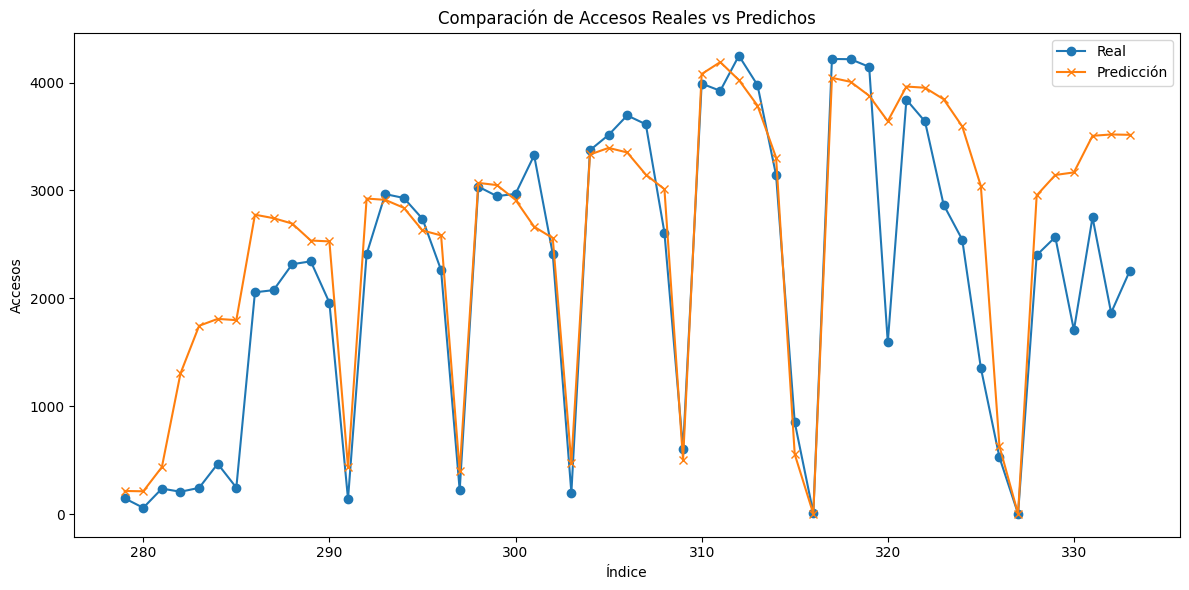

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Real', marker='o')
plt.plot(y_test.index, y_pred, label='Predicción', marker='x')
plt.xlabel('Índice')
plt.ylabel('Accesos')
plt.title('Comparación de Accesos Reales vs Predichos')
plt.legend()
plt.tight_layout()
plt.show()